# Noisy quantum metrology: multi-qubit

In [1]:
import itertools

import equinox as eqx
import jax
import jax.numpy as jnp
import seaborn as sns
import ultraplot as uplt

from squint.circuit import Circuit
from squint.ops.base import SharedGate, Wire
from squint.ops.dv import Conditional, DiscreteVariableState, HGate, RZGate, XGate
from squint.ops.noise import BitFlipChannel
from squint.simulator.tn import Simulator
from squint.utils import partition_op

In [7]:
dim = 2
n = 8
wires = [Wire(dim=dim, idx=i) for i in range(n)]

circuit = Circuit()
for w in wires:
    circuit.add(DiscreteVariableState(wires=(w,), n=(0,)))

circuit.add(HGate(wires=(wires[0],)))
for i in range(n - 1):
    circuit.add(Conditional(gate=XGate, wires=(wires[i], wires[i + 1])))

circuit.add(
    SharedGate(op=RZGate(wires=(wires[0],), phi=0.1 * jnp.pi), wires=tuple(wires[1:])),
    "phase",
)

for w in wires:
    circuit.add(HGate(wires=(w,)))


circuit.add(
    SharedGate(op=BitFlipChannel(wires=(wires[0],), p=0.2), wires=tuple(wires[1:])),
    # SharedGate(op=DepolarizingChannel(wires=(wires[0],), p=0.2), wires=tuple(wires[1:])),
    "noise",
)

params, static = eqx.partition(circuit, eqx.is_inexact_array)
params_phase, params_noise = partition_op(params, "phase")
params = (params_phase, params_noise)
sim = Simulator.compile(static, params_phase, params_noise)

In [8]:
path = sim.subscripts
print(path)

a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,aq,br,qcsu,rdtv,uewy,vfxz,ygAC,zhBD,CiEG,DjFH,GkIK,HlJL,KmMO,LnNP,OoQS,PpRT,sU,tV,wW,xX,AY,BZ,EÀ,FÁ,IÂ,JÃ,MÄ,NÅ,QÆ,RÇ,SÈ,TÉ,UÊ,VË,WÌ,XÍ,YÎ,ZÏ,ÀÐ,ÁÑ,ÂÒ,ÃÓ,ÄÔ,ÅÕ,ÆÖ,Ç×,ÈØ,ÉÙ,쏜ÊÚ,쏜ËÛ,쏞ÌÜ,쏞ÍÝ,쏠ÎÞ,쏠Ïß,쏢Ðà,쏢Ñá,쏤Òâ,쏤Óã,쏦Ôä,쏦Õå,쏨Öæ,쏨×ç,쏪Øè,쏪Ùé->ÚÜÞàâäæèÛÝßáãåçé


In [11]:
# ps = jnp.linspace(0, 0.5, 50)
ps = jnp.logspace(-8, -2, 50)

params_noise = eqx.tree_at(lambda pytree: pytree.ops["noise"].op.p, params_noise, ps)
params_phase = eqx.tree_at(
    lambda pytree: pytree.ops["phase"].op.phi, params_phase, jnp.ones_like(ps) * 0.01
)

cfims = jax.vmap(sim.probabilities.cfim)(params_phase, params_noise)

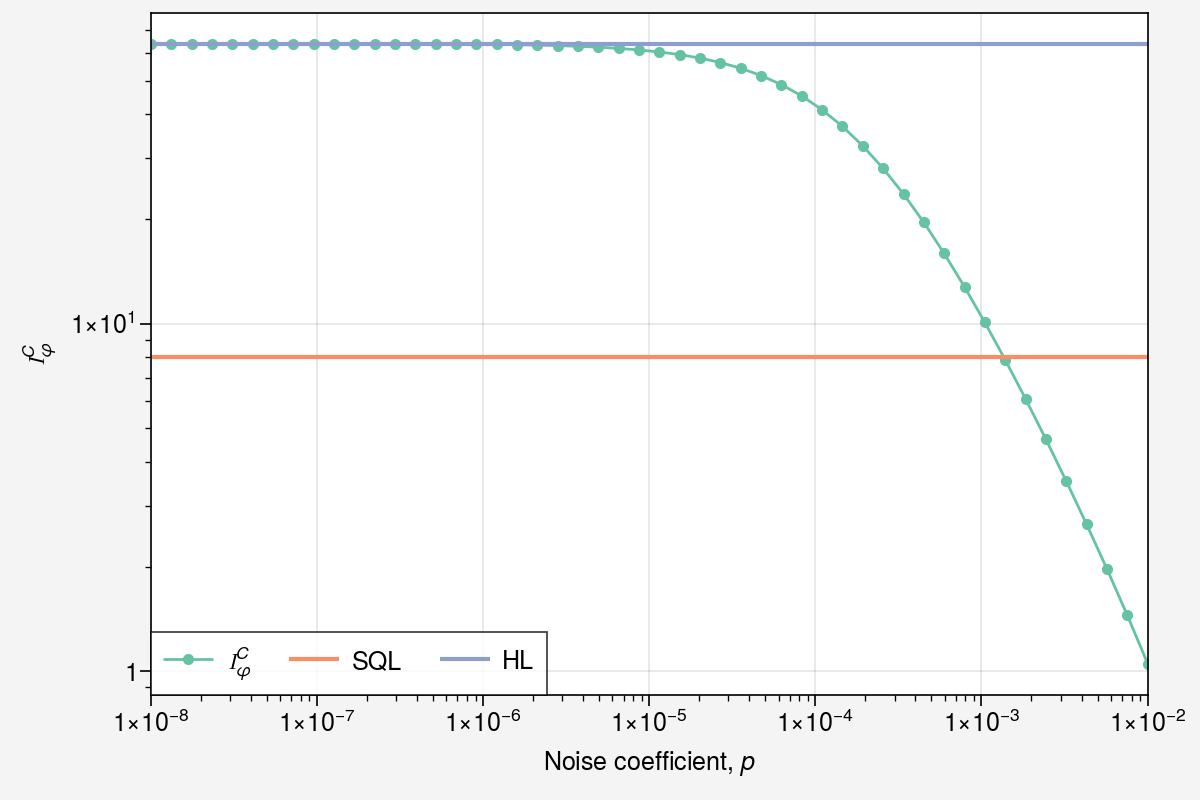

In [12]:
colors = itertools.cycle(sns.color_palette("Set2", n_colors=3))
fig, ax = uplt.subplots(nrows=1, figsize=(6, 4), sharey=False)

ax.plot(
    ps,
    cfims,
    color=next(colors),
    label=r"$\mathcal{I}_\varphi^C$",
    marker="o",
    markersize=3,
    linewidth=1,
)

ax.axhline(n, label="SQL", color=next(colors))
ax.axhline(n**2, label="HL", color=next(colors))
ax.set(
    xlabel=r"Noise coefficient, $p$",
    ylabel=r"$\mathcal{I}_\varphi^C$",
    # ylim=[0, 1.05 * jnp.max(cfims)],
    yscale="log",
    xscale="log",
)
ax.format(xformatter="sci", yformatter="sci")
ax.legend();